In [1]:
from evautils import sequtils
import numpy as np
from collections import OrderedDict
import h5py
import gzip

In [2]:
def load_sequences(seqfile):
    seqs = OrderedDict()
    fp = gzip.open(seqfile, "rb")
    print("#Loading " + seqfile + " ...")
    for line in fp:
        line=line.decode('utf8').split()
        seqs[line[0]] = line[1]
    fp.close()
    print("#Loaded " + str(len(seqs)) + " sequences from " + seqfile)
    return seqs

In [3]:
SCORES_FILE = '/users/eprakash/git/interpret-benchmark/scripts/project/H1_project.h5'
SEQ_FILE = '/users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/H1/sequences/top_10k_sim_positives.txt.gz'
MOTIF_MATCHES_FILE='/users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/H1/sequences/reduced_sim_fimo_out/fimo.txt'
motif_matches = sequtils.load_fimo_motif_matches(MOTIF_MATCHES_FILE, True)
seqs=load_sequences(SEQ_FILE)

#Loading /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/H1/sequences/reduced_sim_fimo_out/fimo.txt ...
#Loaded 4452974 motif matches in 912909 sequences
#Loading /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/H1/sequences/top_10k_sim_positives.txt.gz ...
#Loaded 10000 sequences from /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/H1/sequences/top_10k_sim_positives.txt.gz


In [4]:
for key in list(motif_matches.keys()):
    if key not in list(seqs.keys()):
        del motif_matches[key]

In [4]:
h5f = h5py.File(SCORES_FILE,'r')
deeplift_rcrs_shuff20_scores=np.array(h5f.get("deeplift-rcrs_ref:shuff-20"))
seqids = [x.decode('utf-8') for x in np.array(h5f.get("seqids"))]
h5f.close()
method_to_saved_scores = OrderedDict([('deeplift_rcrs_shuff20', deeplift_rcrs_shuff20_scores)])

In [7]:
relevant_indices_list = range(len(seqs))
relevant_labels_list = list(seqs.keys())

In [8]:
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seqs[label]) for label in relevant_labels_list])

chr3:67384804-67385204

deeplift_rcrs_shuff20


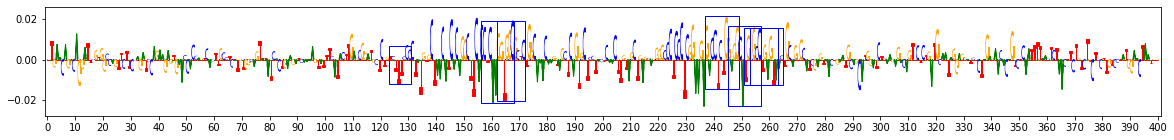

In [9]:
%matplotlib inline
from deeplift.visualization import viz_sequence
examples = ['chr3:67384804-67385204']
methods = ['deeplift_rcrs_shuff20']
for ex in examples:
    print(ex + "\n")
    for method in methods:
        print(method)
        idx = relevant_indices_list[relevant_labels_list.index(ex)]
        scores_for_idx = method_to_saved_scores[method][idx]
        onehot_for_idx = onehot_data[idx]
        scores_for_idx = onehot_for_idx*scores_for_idx[:,None]
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight={'blue':[(motif['begin'],motif['end']) for motif in motif_matches[ex]]})